In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Sampler
from qiskit import QuantumCircuit

In [6]:
# Save an IBM Cloud account:
# QiskitRuntimeService.save_account(channel="ibm_cloud", token="MY_IBM_CLOUD_API_KEY", instance="MY_IBM_CLOUD_CRN")

# Save an IBM Quantum account:
QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token="092397c1ab0eb92cd2335f151025798f3ab87b5434ea66da89e9e3b9d560302ebf8813a3eb26cf19605d6a5007a3fe7f82b330d0b715677b6fc81ea04b843af9",
    overwrite=True,
)

In [9]:
service_cloud = QiskitRuntimeService(channel="ibm_quantum")

In [11]:
service_cloud.backends()

[<IBMBackend('ibm_osaka')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyoto')>]

In [12]:
from qiskit.circuit.library import MCMT

diffuser = QuantumCircuit(4, name="diffuser")
diffuser.h([0, 1, 2, 3])
diffuser.x([0, 1, 2, 3])
diffuser.barrier()
diffuser.h(3)
diffuser.mcx([0, 1, 2], 3)
diffuser.h(3)
diffuser.barrier()
diffuser.x([0, 1, 2, 3])
diffuser.h([0, 1, 2, 3])
diffuser.draw()

oracle = QuantumCircuit(4, name="oracle")
oracle.x(1)
oracle.x(2)
# oracle.mcp(math.pi / 2, [0, 1, 2], 3)
mcz = MCMT("cz", 3, 1)
oracle.compose(mcz, [0, 1, 2, 3], inplace=True)
oracle.x(1)
oracle.x(2)


grover = QuantumCircuit(4, 4)
grover.h([0, 1, 2, 3])

for i in range(2):
    grover.append(oracle, [0, 1, 2, 3])
    grover.append(diffuser, [0, 1, 2, 3])
grover.measure([0, 1, 2, 3], [0, 1, 2, 3])

In [13]:
options = Options(optimization_level=1)
options.execution.shots = 1024

with Session(service=service_cloud, backend="ibmq_qasm_simulator") as session:
    sampler = Sampler(session=session, options=options)
    job = sampler.run(circuits=grover)
    result = job.result()
    print(f"Job ID is {job.job_id()}")
    print(f"Job result is {result}")

    #  More executions (of Sampler and/or Estimator) can go here to leverage the session

Job ID is clu5bj1054sir2br63m0
Job result is SamplerResult(quasi_dists=[{11: 0.0048828125, 1: 0.0087890625, 2: 0.00390625, 8: 0.005859375, 3: 0.0068359375, 0: 0.0068359375, 7: 0.0078125, 10: 0.001953125, 15: 0.0068359375, 9: 0.9150390625, 5: 0.0048828125, 12: 0.0029296875, 14: 0.00390625, 13: 0.009765625, 4: 0.0048828125, 6: 0.0048828125}], metadata=[{'shots': 1024, 'circuit_metadata': {}}])


In [14]:
print(f" > Quasi probability distribution: {result.quasi_dists[0]}")
print(f" > Metadata: {result.metadata[0]}")

 > Quasi probability distribution: {11: 0.0048828125, 1: 0.0087890625, 2: 0.00390625, 8: 0.005859375, 3: 0.0068359375, 0: 0.0068359375, 7: 0.0078125, 10: 0.001953125, 15: 0.0068359375, 9: 0.9150390625, 5: 0.0048828125, 12: 0.0029296875, 14: 0.00390625, 13: 0.009765625, 4: 0.0048828125, 6: 0.0048828125}
 > Metadata: {'shots': 1024, 'circuit_metadata': {}}


In [15]:
program_inputs = {
    "circuits": grover,
    "circuit_indices": [0],
}

options = {"backend": "ibmq_qasm_simulator"}
job = service_cloud.run(program_id="sampler", options=options, inputs=program_inputs)
print(job.job_id())

result = job.result()
print(result)

clu5bn8iidfp3m82g2v0
SamplerResult(quasi_dists=[{0: 0.0107421875, 1: 0.0087890625, 2: 0.0068359375, 3: 0.005859375, 4: 0.0029296875, 5: 0.0029296875, 6: 0.0146484375, 7: 0.0078125, 8: 0.0048828125, 9: 0.904296875, 10: 0.00390625, 11: 0.0048828125, 12: 0.0087890625, 13: 0.0029296875, 14: 0.005859375, 15: 0.00390625}], metadata=[{'shots': 1024, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.0, 'readout_mitigation_time': 0.06370956799946725}])


In [16]:
result_dict = result.quasi_dists[0].binary_probabilities()

print(result_dict)

{'0000': 0.0107421875, '0001': 0.0087890625, '0010': 0.0068359375, '0011': 0.005859375, '0100': 0.0029296875, '0101': 0.0029296875, '0110': 0.0146484375, '0111': 0.0078125, '1000': 0.0048828125, '1001': 0.904296875, '1010': 0.00390625, '1011': 0.0048828125, '1100': 0.0087890625, '1101': 0.0029296875, '1110': 0.005859375, '1111': 0.00390625}


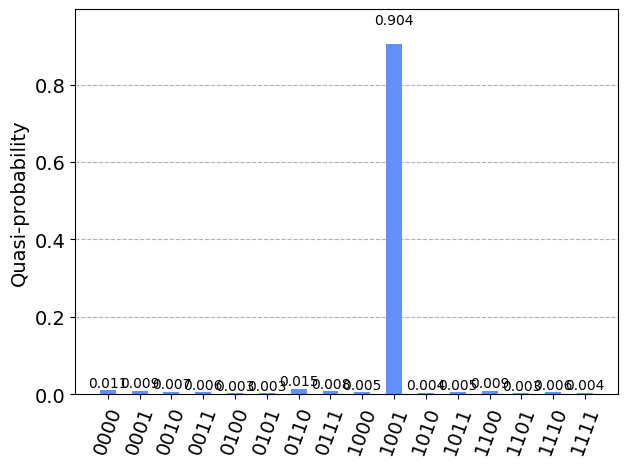

In [18]:
from qiskit.visualization import plot_histogram

plot_histogram(result_dict)

### Exercise 7.2

In [24]:
from qiskit.quantum_info import SparsePauliOp

from qiskit_ibm_runtime import QiskitRuntimeService, Estimator

service = QiskitRuntimeService(channel="ibm_quantum")

psi1 = QuantumCircuit(2, name="psi")
psi1.x(1)

H1 = SparsePauliOp.from_list([("ZZ", 1)])

with Session(service=service, backend="ibmq_qasm_simulator") as session:
    estimator = Estimator(session=session)

    psi1_H1 = estimator.run(circuits=[psi1], observables=[H1])
    print(psi1_H1.result())

EstimatorResult(values=array([-1.]), metadata=[{'variance': 0.0, 'shots': 4000}])


### Exercise 7.3

In [48]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import QuantumCircuit
import math

# define your parameters
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator

service = QiskitRuntimeService(channel="ibm_quantum")

length = 10
circuits = []
for i in range(length):
    psi1 = QuantumCircuit(2, name="psi")
    psi1.ry((i + 1) / length * math.pi, 0)
    psi1.x(1)
    circuits.append(psi1)

H1 = SparsePauliOp.from_list([("ZZ", -0.3), ("XX", -0.5), ("YY", -0.4)])
Hs = [H1] * length

with Session(service=service, backend="ibmq_qasm_simulator") as session:
    estimator = Estimator(session=session)

    psi1_H1 = estimator.run(
        circuits=circuits,
        observables=Hs,
    )
    print(psi1_H1.result())

EstimatorResult(values=array([ 0.285  ,  0.23325,  0.1637 ,  0.0842 ,  0.00155, -0.0748 ,
       -0.1669 , -0.23495, -0.282  , -0.31275]), metadata=[{'variance': 0.418933895, 'shots': 4000}, {'variance': 0.43992740750000003, 'shots': 4000}, {'variance': 0.46953595000000004, 'shots': 4000}, {'variance': 0.4926982750000001, 'shots': 4000}, {'variance': 0.49976868750000003, 'shots': 4000}, {'variance': 0.492698175, 'shots': 4000}, {'variance': 0.4680675900000001, 'shots': 4000}, {'variance': 0.4406196975000001, 'shots': 4000}, {'variance': 0.41987889500000003, 'shots': 4000}, {'variance': 0.4099134375000001, 'shots': 4000}])
